Replicating This: https://www.youtube.com/watch?v=l8pRSuU81PU

In [2]:
from transformers import GPT2LMHeadModel

In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124 M
sd_hf = model_hf.state_dict()


for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

- 50257 tokens and 768 size embedding
- 1024 max sequence length that can attend to. 

In [4]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

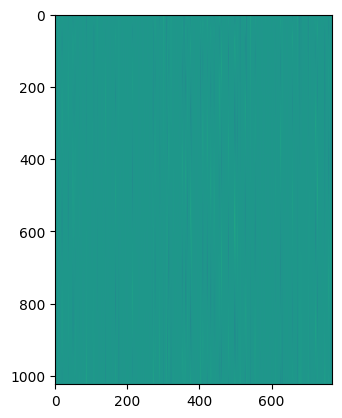

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"])

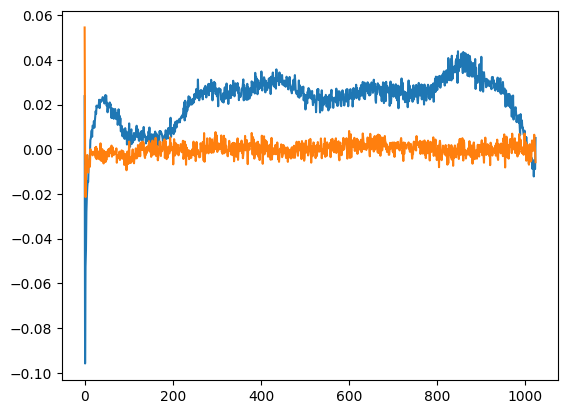

In [6]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])  ## the value of the 250th embedding channel across the 1024 positions
plt.plot(sd_hf["transformer.wpe.weight"][:, 767])

In [7]:
from transformers import pipeline, set_seed
generator = pipeline("text-generation", model='gpt2', device=0)
set_seed(42)
generator("Hello, I am a language model,", max_length=30, num_return_sequences=5)

/home/kyan/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': 'Hello, I am a language model, for you understand that it is better to be a machine-readable, binary code, not human readable, binary'},
 {'generated_text': "Hello, I am a language model, you know.\n\nThat's right… I have a lot of friends who don't know what I do"},
 {'generated_text': "Hello, I am a language model, not a human. I'm writing this because I wanted to get at the core of your desire for a model"},
 {'generated_text': 'Hello, I am a language model, a model of knowledge, my model of the world. And we all know this, and we all know it'},
 {'generated_text': 'Hello, I am a language model, a set of rules for our language, built on immutable information and with the support of immutable data representations. We'}]

Main differences between GPT2 and GPT

Training model

- needs a dataset




In [8]:
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [9]:
with open('input.txt', 'r') as f:
    text =f.read()

data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [10]:
import tiktoken

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [11]:
# need to get in (B, T) 

import torch
buf = torch.tensor(tokens[:24])
x = buf.view(4,6)
print(x)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])


In [13]:
# issue, token number 13 there is no ground truth
# solution:

import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4,6) # up until the last token
y = buf[1:].view(4,6) # from the first token onwards
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


Our vocab network is 50257

- expected loss 


-ln(1/50257).

- negative log likelihood